## Importing all necessary libraries

In [20]:
!pip install scikit-learn-intelex ## for x86 only

In [1]:
import pandas as pd
import numpy as np
from PIL import Image

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import MiniBatchKMeans

from sklearn.svm import SVC
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

In [2]:
## If your CPU Intel, you may use this to speed up training process

from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [8]:
from sklearnex import unpatch_sklearn
unpatch_sklearn()

## Reading Data and basic Feature Extraction

In [3]:
def read_data(mode="train", p=0.2, seed=None):
    """
    Read the training/testing files and return the input data and labels.

    Parameters:
    ----------
    mode (str): 'train' or 'test' to read the training or testing data.
    p (float): fraction of the data to read. Useful for debugging.
    seed (int): random seed to use for reproducibility.

    Returns:
    -------
    X (np.array): input data
    y (np.array): labels
    """
    if mode == "train" or mode == "test":
        data = pd.read_csv('train.csv')
        mode = "train"
    elif mode == "predict":
        data = pd.read_csv('test.csv')
        mode = "test"
    else:
        raise ValueError("mode must be 'train' or 'test' or 'predict'")

    if mode != "test":
        if seed is None:data = data.sample(frac=p)
        else: data = data.sample(frac=p, random_state=seed)

    X = data['im_name'].apply(lambda filename: np.asarray(Image.open(f"{mode}_ims/{filename}"))).values
    y = data['label'].values
    X = np.stack(X).reshape(-1, 32*32*3)

    return X, y

In [4]:
def predict_data(predictedLabels, fp='test.csv'):
    """
    Writes and predicts the testing files.

    Parameters:
    ----------
    predictedLabels (np.array): predicted labels for the testing data.
    fp (str): filepath to write the predicted labels.

    Returns:
    -------
    None
    """
    data = pd.read_csv('test.csv')
    data['label'] = predictedLabels
    data.to_csv(fp, index=False)

In [5]:
trainData, trainLabels = read_data("train", p=1, seed=69)
trainData, testData, trainLabels, testLabels = train_test_split(trainData, trainLabels, test_size=0.2, random_state=69)
print([sum(trainLabels == i) for i in range(10)])
trainData.shape, trainLabels.shape, testData.shape, testLabels.shape

[4017, 3973, 4033, 4009, 3960, 3992, 3984, 4007, 4069, 3956]


((40000, 3072), (40000,), (10000, 3072), (10000,))

In [6]:
predictData, predictLabels = read_data("predict", p=1)
predictData.shape, predictLabels.shape

((10000, 3072), (10000,))

## K-means and whitening Feature Extraction

In [7]:
PATCH_SHAPE = (6, 6)
def mem_str(A):
    return str(A.shape[0]*A.shape[1]*8/(1024*1024*1024))+'GB' # Currently using float64, shd change to float32 later

In [8]:
def patchStandardize(patches):
    """
    Standardizes patches by P_norm = (P - mean)/sqrt(var + 10).
    """
    patches *= 255
    patches -= patches.mean(axis=1, keepdims=True)
    _var = patches.var(axis=1, keepdims=True) + 10
    patches /= np.sqrt(_var)
    return patches / 255

In [9]:
def getRandomPatches(img, patchSize, k):
    patches = np.empty((img.shape[0] * k, patchSize[0] * patchSize[1] * 3))
    img_samples = np.random.randint(0, img.shape[0], img.shape[0] * k)
    row_samples = np.random.randint(0, img.shape[1] - patchSize[0] + 1, img.shape[0] * k)
    col_samples = np.random.randint(0, img.shape[2] - patchSize[1] + 1, img.shape[0] * k)
    for i, (imgIdx, rowIdx, colIdx) in enumerate(zip(img_samples, row_samples, col_samples)):
        patches[i] = img[imgIdx, rowIdx:rowIdx+patchSize[0], colIdx:colIdx+patchSize[1]].ravel()
    return patches

In [10]:
def enchanceImg(img):
    _width = int(np.sqrt(img.shape[1] / 3))
    img = img.reshape(_width, _width, 3)
    return (img - img.min())/(img.max() - img.min())

In [11]:
class Whiten():
    def __init__(self, eps=1e-2):
        self.eps = eps
        self.mean = None
        self.W = None
    def zca(self, A):
        """
        We aim to find a linear transformation W of X, such that the cov() on the transformed result of X will be diagonal. 
        We add two more restrictions:
        1. The co-variance result should be close to the identity (diagnoal restricted to 1's). 
        2. W should be symetric W = W.T
        with these restirctions, the math expression can be found at : (see the formula development at: page 48 at https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf)
        """
        U, S, V = np.linalg.svd(A.T @ A / A.shape[1] , full_matrices=True)
        self.W = U @ np.diag(1.0/np.sqrt(S + self.eps)) @ U.T
        return np.dot(A, self.W)
    def fit_transform(self, X):
        self.mean = np.mean(X, axis=0)
        return self.zca(X - self.mean)
    def transform(self, X):
        return (X - self.mean) @ self.W

In [15]:
from sklearn.feature_extraction import image

class KMeansEmbedding():
    def __init__(self, k, seed=None):
        self.k = k
        self.seed = seed
        self.kmeans = MiniBatchKMeans(n_clusters=k, n_init='auto', random_state=seed)
        self.batchSize = 5000
        self.patchSize = PATCH_SHAPE
        self.poolShape = (2, 2)
        self.patchExtractor = image.PatchExtractor(patch_size=self.patchSize,random_state=seed)
    def partial_fit(self, X):
        self.kmeans.partial_fit(X)
    def _transform(self, X):
        distances = self.kmeans.transform(X)
        embedding = np.clip(distances.mean(axis=1, keepdims=True) - distances, 0, None)
        return embedding
    def transform(self, X, whitener):
        embedding = np.zeros((X.shape[0], self.poolShape[0]*self.poolShape[1]*self.k))
        for imgIdx in range(0, X.shape[0], self.batchSize):
            _X = X[imgIdx:imgIdx+self.batchSize]
            poolZoneShape = ((_X.shape[1]-self.patchSize[0]+1)//self.poolShape[0], (_X.shape[2]-self.patchSize[1]+1)//self.poolShape[1])
            zone = 0
            for zone_x in range(0, self.poolShape[0]*poolZoneShape[0], poolZoneShape[0]):
                for zone_y in range(0, self.poolShape[1]*poolZoneShape[1], poolZoneShape[1]):
                    patches = self.patchExtractor.transform(_X[:, zone_x:zone_x+poolZoneShape[0]+self.patchSize[0]-1, zone_y:zone_y+poolZoneShape[1]+self.patchSize[1]-1])
                    patches = patches.reshape(patches.shape[0], -1)
                    patches = patchStandardize(patches)
                    patches = whitener.transform(patches)
                    embedding[imgIdx:imgIdx+self.batchSize, zone*self.k:(zone+1)*self.k] = self._transform(patches).reshape(_X.shape[0], int(patches.shape[0]/_X.shape[0]), self.k).sum(axis=1)
                    zone += 1
        return embedding

In [16]:
kmeansEmbedding = KMeansEmbedding(800, seed=69)
whitener = Whiten()

Num of iters = 8
Total Patches = 4000000
Features per step per image = 13
Each iter requires 0.4184 GB of memory
Before Whitening


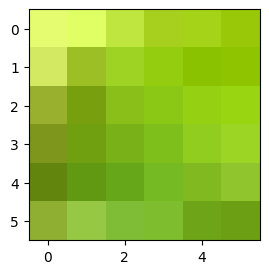

After Whitening


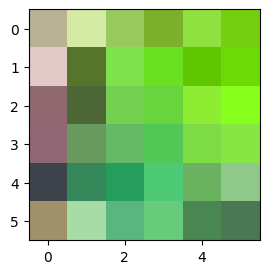

Iteration 0/8 done
Iteration 1/8 done
Iteration 2/8 done
Iteration 3/8 done
Iteration 4/8 done
Iteration 5/8 done
Iteration 6/8 done
Iteration 7/8 done


In [17]:
whitenerBatch = 25000*100//5

totPatches = len(trainData) * 100
totSteps = int(np.ceil(totPatches/whitenerBatch))
featuresPerStepPerImg = int(np.ceil(totPatches/totSteps/len(trainData)))
print(f"Num of iters = {totSteps}\nTotal Patches = {totPatches}\nFeatures per step per image = {featuresPerStepPerImg}\nEach iter requires {featuresPerStepPerImg*len(trainData)*PATCH_SHAPE[0]*PATCH_SHAPE[1]*3*8/(1024*1024*1024):.4f} GB of memory")
for i in range(totSteps):
    patches = getRandomPatches(trainData.reshape(-1, 32, 32, 3), PATCH_SHAPE, featuresPerStepPerImg)
    patches = patchStandardize(patches)
    if i == 0:
        print("Before Whitening")
        plt.figure(figsize=(3, 3))
        plt.imshow(enchanceImg(patches[:1]))
        plt.show()
        patches = whitener.fit_transform(patches.reshape(-1, PATCH_SHAPE[0]*PATCH_SHAPE[1]*3))
        print("After Whitening")
        plt.figure(figsize=(3, 3))
        plt.imshow(enchanceImg(patches[:1]))
        plt.show()
    else:
        patches = whitener.transform(patches.reshape(-1, PATCH_SHAPE[0]*PATCH_SHAPE[1]*3))
    kmeansEmbedding.partial_fit(patches)
    print(f"Iteration {i+1}/{totSteps} done")

In [18]:
trainData_Embedding = kmeansEmbedding.transform(trainData.reshape(-1, 32, 32, 3), whitener)
testData_Embedding = kmeansEmbedding.transform(testData.reshape(-1, 32, 32, 3), whitener)
predictData_Embedding = kmeansEmbedding.transform(predictData.reshape(-1, 32, 32, 3), whitener)
trainData_Embedding.shape, testData_Embedding.shape, predictData_Embedding.shape

((40000, 3200), (10000, 3200), (10000, 3200))

In [19]:
trainData_Embedding[0, :10]

array([1.88130008, 2.04769684, 0.07840176, 1.66752202, 2.28936141,
       2.17309582, 1.70954833, 2.73055598, 1.59098838, 2.55868996])

In [20]:
from sklearn import svm

svm = svm.LinearSVC(C=0.5, dual=False, random_state=69)
svm.fit(trainData_Embedding, trainLabels)

LinearSVC(C=0.5, dual=False, random_state=69)

In [21]:
test_pred = svm.predict(testData_Embedding)
(test_pred == testLabels).mean()

0.7405

In [ ]:
# erm slow
train_pred = svm.predict(trainData_Embedding)
(train_pred == trainLabels).mean()

0.756425

Text(0, 0.5, 'True')

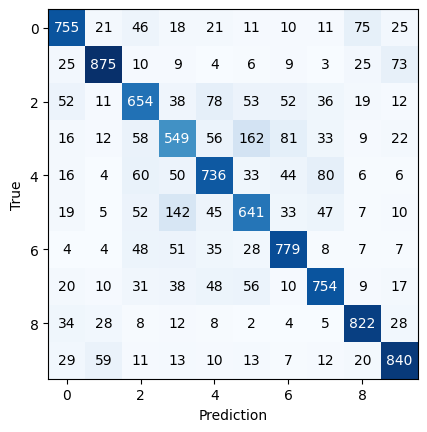

In [23]:
cm = confusion_matrix(testLabels, test_pred)
plt.imshow(cm, cmap='Blues')
for i in range(10):
    for j in range(10):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black' if cm[i, j] < cm.max()/2 else 'white')
plt.xlabel("Prediction")
plt.ylabel("True")